<a href="https://colab.research.google.com/github/lalitpandey02/PythonNotebooks/blob/main/3_Hands_on_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="100" /></center>

<center><h1>DCGAN (Deep Convolution GAN)</center>

---
# **Table of Contents**
---

**1.** [**Introduction**](#section1)<br>
**2.** [**GAN using MNIST Dataset**](#section2)<br>
  - **2.1** [**Importing Packages**](#section201)
  - **2.2** [**Load and Prepare the Dataset**](#section202)
  - **2.3** [**Create the Models**](#section203)
  - **2.4** [**Define the Loss and Optimizers**](#section204)
  - **2.5** [**Save Checkpoints**](#section205)
  - **2.6** [**Define the Training Loop**](#section206)
  - **2.7** [**Train the Model**](#section207)
  - 2.8 [**Create a GIF**](#section208)

---
<a name = Section1></a>
# **1. Introduction**
---

- **Generative Adversarial Networks (GANs)** are used for generation of new data i.e. images. It consists of two distinct models, a generator and a discriminator, competing with each other.

- A Deep Convolutional GAN (DCGAN) is an **extension** of the GAN, except that it explicitly uses **convolutional** and **transpose-convolutional** layers in the discriminator and **generator**, respectively.

- A discriminator is made up of **strided** convolution layers, **batch norm** layers, and **LeakyReLU** activations without **max-pooling** layers i.e. **convolution** > **batch norm** > **leaky ReLU**

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/dc1.png" width="900" height="400"></center>

- A Deep Convolution GAN (DCGAN) does something very simialr to GAN, but specifically

  - Focuses on using **Deep Convolutional Networks** in place of those fully-connected networks.

  - Conv nets in general find areas of **correlation** within an image, that is, they look for **spatial correlations**.

  - It means that a **DCGAN** would likely be more fitting for **image/video** data.

- #### **In order to improve GAN, these ideas are introduced:**

  - **Replace** all max pooling with **convolutional stride**.

  - Use **transposed** convolution for **upsampling**.

  - **Eliminate** fully connected layers.

  - Use **`Batch Normalization`** **exept** the **output layer** for the *generator*.

  - Use **`LeakyReLU`** in the *generator* except for the **output** which uses **`tanh`**.

  - Use **`LeakyReLU`** in the discriminator.

<a id=section2></a>
# **2. GAN using MNIST Dataset**

<a id=section201></a>
### **2.1 Importing Packages**

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
# Used to plot the gif in the notebook
import tensorflow_docs.vis.embed as embed

<a id=section202></a>
### **2.2 Load and Prepare the Dataset**

- We will use the **MNIST** dataset to train the generator and the discriminator.

- The generator will **generate handwritten digits** resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<a id=section203></a>
### **2.3 Create the Models**

- Both the generator and discriminator are defined using the Keras Sequential API.

#### **The Generator**

- The generator uses **`tf.keras.layers.Conv2DTranspose`** (upsampling) layers to produce an image from a **seed** (random noise).

- Starts with a **`Dense`** layer that takes this seed as input, then **upsample** several times until we reach the **desired** image size of **`28x28x1`**.

- Notice the **`tf.keras.layers.LeakyReLU`** activation for each layer, except the **output** layer which uses **`tanh`**.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

- Using the (as yet **untrained**) generator to **create** an image.

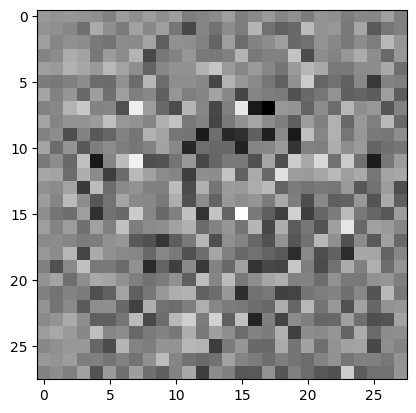

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### **The Discriminator**

- The discriminator is a **CNN-based image classifier**.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

- Using the (as yet **untrained**) discriminator to **classify** the **generated images** as `real` or `fake`.

- The model will be trained to output **positive** values for **real** images, and **negative** values for **fake** images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00125537]], shape=(1, 1), dtype=float32)


**Observation:**

- We get a **negative** value, meaning the image is classified as a **fake**.

<a id=section204></a>
### **2.4 Define the Loss and Optimizers**


- Define loss functions and optimizers for both models.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### **Discriminator Loss**

- This method **quantifies** how well the discriminator is able to **distinguish** real images from fakes.

- It compares:

  - Discriminator's predictions on **real images** to an array of 1s
  
  - Discriminator's predictions on **fake (generated)** images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### **Generator Loss**

- The generator's loss **quantifies** how well it was able to **trick** the **discriminator**.

- Intuitively, if the generator is **performing** well, the discriminator will **classify** the fake images as real (or 1).

- Here, we will compare the discriminators **decisions** on the generated **images** to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**Observations:**

- The discriminator and the generator **optimizers** are **different** since we will **train** two networks **separately**.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

<a id=section205></a>
### **2.5 Save Checkpoints**

- This will help us **save** and **restore** the models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<a id=section206></a>
### **2.6 Define the Training Loop**


In [ ]:
EPOCHS = 80
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- The training loop begins with generator receiving a **random seed** as **input**.

- That seed is used to **produce** an **image**.

- The discriminator is then used to **classify real images** (drawn from the *training* set) and **fakes** images (produced by the *generator*).

- The **loss** is **calculated** for each of these models, and the **gradients** are used to **update** the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

- **Generate and Save Images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

- **Train Function**

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

<a id=section207></a>
### **2.7 Train the Model**

- Call the **`train()`** method defined above to train the **generator** and **discriminator** simultaneously.

- Note, training GANs can be **tricky**.

  - It's important that the generator and discriminator **do not overpower each other** (e.g., that they train at a similar rate).

- At the beginning of the training, the generated images look like **random** noise.

- As training progresses, the generated digits will look **increasingly** real.

- After about 50 epochs, they **resemble** MNIST digits.

- This may take about **30 seconds / epoch** with the default GPU settings on Colab.

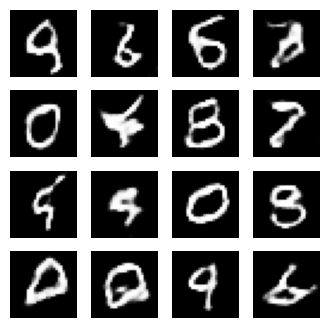

Time for epoch 79 is 11.084582328796387 sec


In [ ]:
train(train_dataset, EPOCHS)

- **Restore the latest checkpoint.**

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<a id=section208></a>
### **2.8 Create a GIF**

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

- Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

- **Visualizing** the `gif`.

In [ ]:
import tensorflow_docs.vis.embed as embed


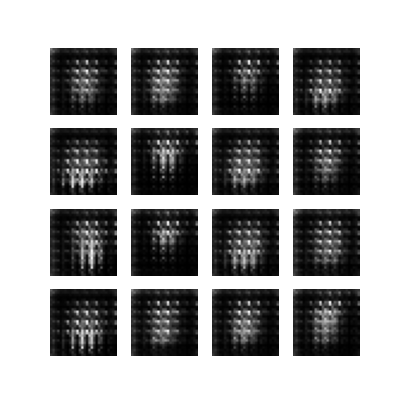

In [ ]:
embed.embed_file(anim_file)

- If you're working in Colab you can **download** the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- **Here is the gif created during our model training**

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/dcgan.gif" width="" height=""></center>